In [1]:
import pandas as pd
import geopandas as gpd
from pathlib import Path
import json
import requests
from IPython.display import JSON

In [2]:
url = "http://ionbeam-ichange.ecmwf-ichange.f.ewcloud.host/api/v1/"

In [3]:
# Load in the ECMWF token 
with open(Path("~/.ecmwfapirc").expanduser(), "r") as f:
    api_creds = json.load(f)

print("Checking API credentials")
r = requests.get(f"https://api.ecmwf.int/v1/who-am-i?token={api_creds['key']}")
if r.status_code == 403: print("Your credentials are either wrong or have expired and need to be renewed at https://api.ecmwf.int/v1/key/")
r.raise_for_status()

# Make a session object the requests library can reuse connections
session = requests.Session()
session.headers["Authorization"] = f"Bearer {api_creds['key']}"

Checking API credentials


In [4]:
stations = session.get(url + "stations").json()
print(f"{len(stations) = }")

len(stations) = 259


In [5]:
from collections import defaultdict, Counter
def map_to_simple_author(authors):
    lls = ["Bologna", "Genova", "Jerusalem", "LLWA", "Barcelona", "Dublin", "CIMA", "Amsterdam"]
    for ll in lls:
        for a in authors:
            if "gert-jan" in a["name"].lower():
                return "Amsterdam", a["name"]
            if ll.lower() in a["name"].lower():
                return ll, a["name"]
    return "/".join(a["name"] for a in authors), None


grouped = defaultdict(Counter)
for s in stations:
    nice_name, original_name = map_to_simple_author(s["authors"])
    grouped[nice_name][original_name] += 1

for ll, breakdown in grouped.items():
    print(f"Living Lab: {ll} - Total datasets: {sum(breakdown.values())}")
    for name, count in breakdown.items():
        print(f"    {name} : {count}")
    print()

Living Lab: Barcelona - Total datasets: 3
    barcelona_living_lab_3 : 3

Living Lab: CIMA - Total datasets: 88
    CIMA I-Change : 88

Living Lab: Genova - Total datasets: 98
    genova_living_lab_7 : 6
    genova_living_lab_1 : 66
    genova_living_lab_19 : 7
    genova_living_lab_27 : 3
    genova_living_lab_12 : 2
    genova_living_lab_29 : 7
    genova_living_lab_28 : 1
    genova_living_lab_21 : 4
    genova_living_lab_8 : 2

Living Lab: Jerusalem - Total datasets: 53
    jerusalem_living_lab_7 : 28
    jerusalem_living_lab_14 : 5
    jerusalem_living_lab_1 : 18
    jerusalem_living_lab_10 : 1
    jerusalem_living_lab_13 : 1

Living Lab: Amsterdam - Total datasets: 17
    Gert-Jan Steeneveld : 17



In [6]:
Counter(s["platform"] for s in stations)

Counter({'meteotracker': 259})

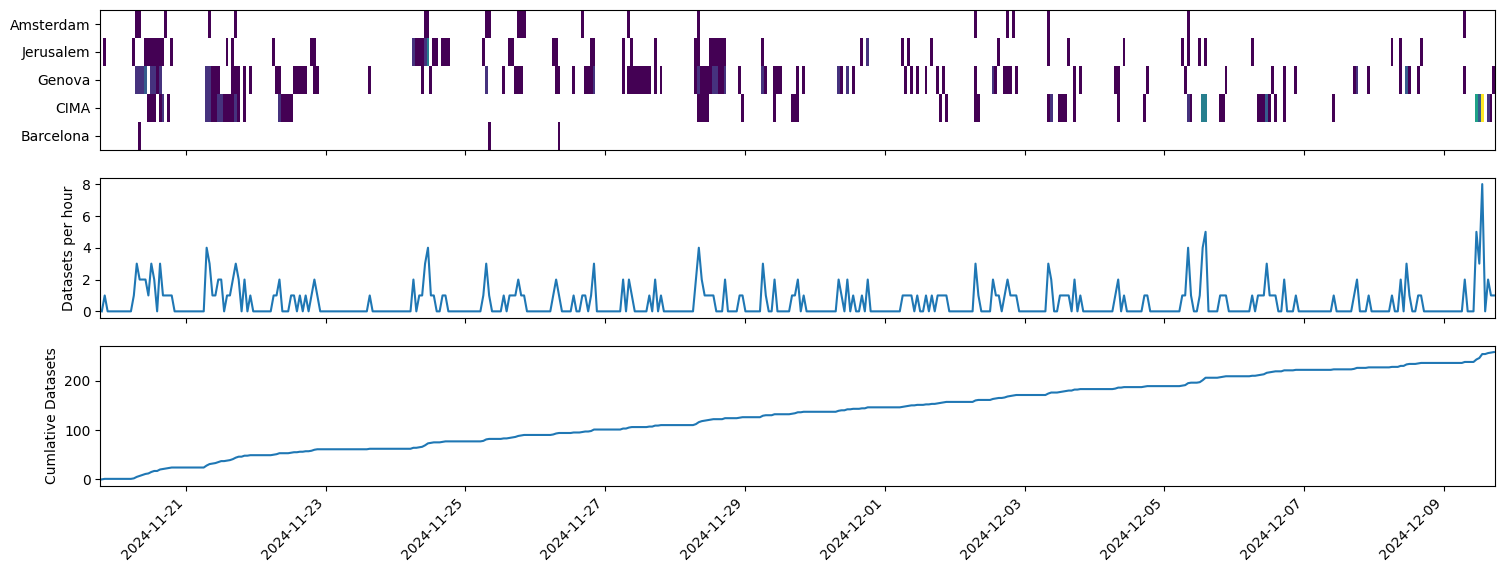

In [9]:
from datetime import datetime as dt
from datetime import timedelta, timezone
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

start = min(dt.fromisoformat(station["time_span"][0]) for station in stations)
end = max(dt.fromisoformat(station["time_span"][1]) for station in stations)

end = dt.now(tz = timezone.utc)
# end = dt(2023, 4, 1, tzinfo = timezone.utc)

times = pd.date_range(start, end + timedelta(hours = 1), freq="1h").to_pydatetime()
station_names = list(grouped.keys())
heatmap = np.zeros(shape = (len(station_names), len(times)))
timeline = np.zeros(shape = len(times))

for station in stations:
    nice_name, _ = map_to_simple_author(station["authors"])
    station_idx = station_names.index(nice_name)
    assert station_idx >= 0
    time_range = pd.date_range(dt.fromisoformat(station["time_span"][0]), dt.fromisoformat(station["time_span"][1]), freq="1h").to_pydatetime()
    time_idxs = times.searchsorted(time_range)
    
    # filter out an times that are outside the range we want
    time_idxs = time_idxs[(0 < time_idxs) & (time_idxs < len(times))]
    heatmap[station_idx, time_idxs] += 1
    
    if len(time_idxs): timeline[time_idxs[0]] += 1

heatmap[np.where(heatmap == 0)] = np.nan

f, axes = plt.subplots(nrows = 3, sharex = True, figsize = (18,7))

ax = axes[0]
ax.pcolormesh(times, station_names, heatmap)
f.autofmt_xdate(rotation=45)

ax = axes[1]
ax.plot(times, timeline)
ax.set(ylabel = "Datasets per hour")

ax = axes[2]
ax.plot(times, timeline.cumsum())
ax.set(ylabel = "Cumlative Datasets");